In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Download data here: https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/

I used 2024 dataset, downloaded in date 2024-06-07

The "year".csv files contain all daily and station elements found in GHCN daily for the given year.  These files are updated daily for the entire period of record.


The following information serves as a definition of each field in one line of data covering one station-day. 
Each field described below is separated by a comma ( , ) and follows the order below:


ID = 11 character station identification code

YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)

ELEMENT = 4 character indicator of element type 

DATA VALUE = 5 character data value for ELEMENT 

M-FLAG = 1 character Measurement Flag 

Q-FLAG = 1 character Quality Flag 

S-FLAG = 1 character Source Flag 

OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am)


See section III of the GHCN-Daily readme.txt file (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) for an explanation of ELEMENT codes and their units as well as the M-FLAG, Q-FLAG and S-FLAG.


The OBS-TIME field is populated with the observation times contained in NOAA/NCEI's HOMR station history database. 

In [2]:
# read data
dataset = pd.read_csv('data/2024.csv', header=None, dtype={1: str, 7: str})

dataset.columns = ['id', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time']

<Axes: ylabel='element'>

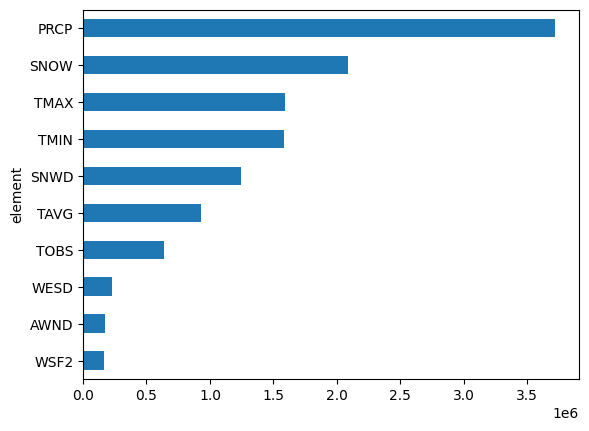

In [3]:
# what is the numerosity of different data?
dataset.groupby('element').size().sort_values(ascending=True).tail(10).plot.barh()

In [4]:
# what is the numerosity of q_flag? This means, how many bad data is there?
dataset.groupby('q_flag', dropna=False).size().sort_values(ascending=False)

q_flag
NaN    13620732
I          6523
L          3743
D          1267
Z          1176
S           768
G           713
O           705
K           453
X           280
M            84
N            69
W            33
T            14
R             4
dtype: int64

In [5]:
# drop rows with quality problems
dataset = dataset.loc[dataset['q_flag'].isna()]

In [6]:
# temperature min and max
temperature = dataset.loc[dataset['element'].isin(['TMIN', 'TMAX'])]

In [7]:
# now we only have hourly temperatures
temperature.groupby('m_flag').size()

m_flag
H    373581
dtype: int64

In [8]:
# make some space
del dataset

In [11]:
temperature.groupby('s_flag').size().sort_values(ascending=False)
# I want to keep the value W, since is the summary of the day
# when in this data available?
temperature = temperature.loc[temperature['s_flag'] == 'W']

In [12]:
# some format
temperature['datetime'] = pd.to_datetime(temperature['date'], format='%Y%m%d')
temperature = temperature[['datetime', 'id', 'value', 'element']]

temperature = temperature.set_index(['datetime', 'id', 'element'])
temperature = temperature['value'].unstack()


In [13]:
temperature = temperature / 10 # temperature is in decimals of celsius degrees
temperature = temperature.sort_index()
# notice that I downloaded data during 2024-06-07 and the last datapoint available is 2024-06-04

In [16]:
temperature.head()

element                 TMAX  TMIN
datetime   id                     
2024-01-01 AQW00061705  31.8  26.3
           CQC00914855  30.6  26.1
           FMW00040308  29.2  25.8
           FMW00040504  32.2  26.1
           FMW00040505  31.2  28.3

<Axes: title={'center': 'Example of Daily Temperature [°C]'}, xlabel='datetime'>

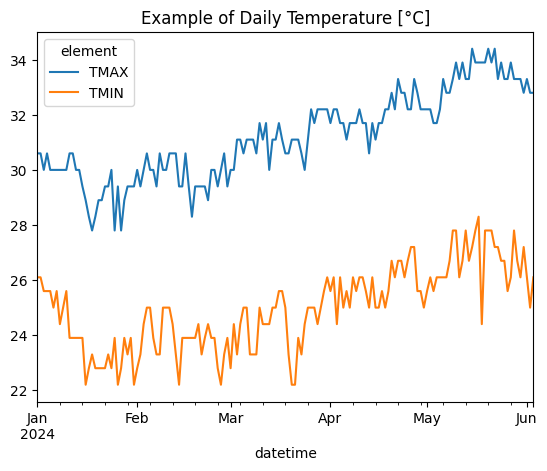

In [17]:
temperature.swaplevel(0,1).loc['CQC00914855'].plot(title='Example of Daily Temperature [°C]')

<Axes: title={'center': 'Fraction of NaNs [%]'}, xlabel='datetime'>

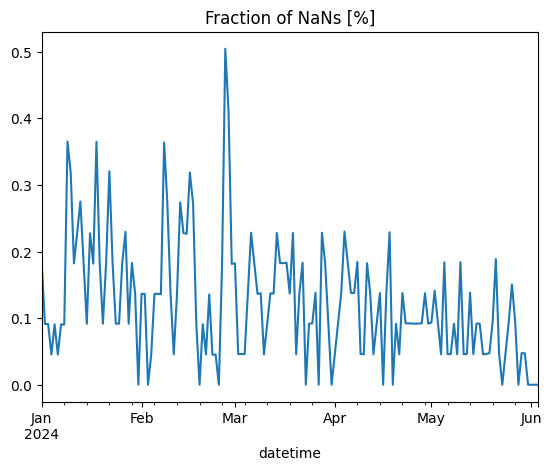

In [18]:
(100 * temperature.isna().groupby('datetime').sum().sum(axis=1) / temperature.groupby('datetime').count().sum(axis=1)).plot(title='Fraction of NaNs [%]')

In [19]:
# let us now map the stations, I just want to keep the US data
list_id = []
list_latitude = []
list_longitude = []
list_elevation = []
list_state = []

with open('data/ghcnd-stations.txt', 'r') as f:
    for line in f:
        # split the spaces
        list_line = line.split(' ')
        # delete the empty characters
        list_line = [line for line in list_line if line != '']

        # mapping file has the following columns:
        # id, latitude, longitude, elevation, state, name, gsn flag, wmo id
        # let's say that we don't care about name, gsn flag and wmo id
        # so we just want to keep the first 5 fields
        # we keep the state just for US contries, for other countries we put the first
        # two letters of the id
        if list_line[0][:2] == 'US':
            list_line = list_line[:5]
            state = list_line[4]
        else:
            list_line = list_line[:4]
            state = list_line[0][:2]
        
        list_id.append(list_line[0])
        list_latitude.append(list_line[1])
        list_longitude.append(list_line[2])
        list_elevation.append(list_line[3])
        list_state.append(state)


In [20]:
mapping_df = pd.DataFrame({
    'id': list_id,
    'latitude': list_latitude,
    'longitude': list_longitude,
    'elevation': list_elevation,
    'state': list_state
})

In [21]:
mapping_df

,id,latitude,longitude,elevation,state
0,ACW00011604,17.1167,-61.7833,10.1,AC
1,ACW00011647,17.1333,-61.7833,19.2,AC
2,AE000041196,25.3330,55.5170,34.0,AE
3,AEM00041194,25.2550,55.3640,10.4,AE
4,AEM00041217,24.4330,54.6510,26.8,AE
...,...,...,...,...,...
125983,ZI000067969,-21.0500,29.3670,861.0,ZI
125984,ZI000067975,-20.0670,30.8670,1095.0,ZI
125985,ZI000067977,-21.0170,31.5830,430.0,ZI
125986,ZI000067983,-20.2000,32.6160,1132.0,ZI


In [22]:
mapping_df['latitude'] = mapping_df['latitude'].astype(float)
mapping_df['longitude'] = mapping_df['longitude'].astype(float)
mapping_df['elevation'] = mapping_df['elevation'].astype(float)

mapping_df = mapping_df.set_index('id')
temperature = temperature.join(mapping_df)

<Axes: ylabel='state'>

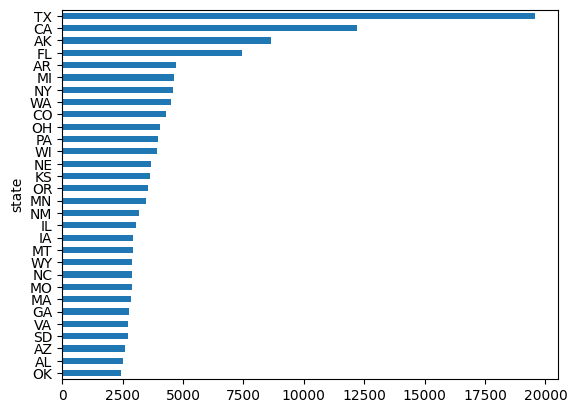

In [23]:
# remember that US states are by their name and not by US label
temperature.groupby('state').size().sort_values(ascending=True).tail(30).plot.barh()

In [24]:
# just keep US data
us_ids = [a for a in list(temperature.index.get_level_values('id').unique()) if 'US' in a]
temperature = temperature.loc[temperature.index.get_level_values('id').isin(us_ids)]

<Axes: title={'center': 'Fraction of NaNs - just US states[%]'}, xlabel='datetime'>

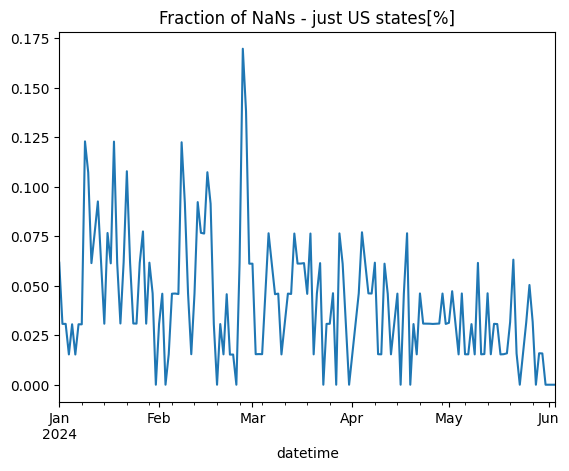

In [25]:
# much better data
(100 * temperature.isna().groupby('datetime').sum().sum(axis=1) / temperature.groupby('datetime').count().sum(axis=1)).plot(title='Fraction of NaNs - just US states[%]')

<Axes: title={'center': 'Example of daily min and max temperatures [°C]'}, xlabel='datetime'>

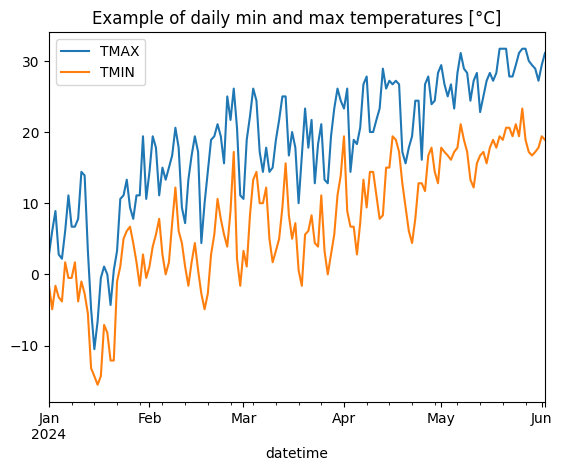

In [29]:
temperature.loc[temperature.index.get_level_values('id') == 'USC00035189', ['TMAX', 'TMIN']].droplevel(1).plot(title='Example of daily min and max temperatures [°C]')